In [22]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import truncnorm,norm
def fit_truncated_normal(r,loc_guess=30,scale_guess=90,xa=30,xb=250):
    from scipy.stats import truncnorm,norm
    from scipy.optimize import fmin_slsqp
    def func(p, r, xa, xb): 
        return truncnorm.nnlf(p, r)
    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]
    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(r, xa, xb),
                 iprint=False, iter=1000)
    return par

def cdf_to_pmf(cdf_values):
    if cdf_values[0] < 0 or cdf_values[-1] != 1.0:
        raise ValueError("CDF must start at 0 (implicitly) and end at 1.")
    if not np.all(np.diff(cdf_values) >= 0):
        raise ValueError("CDF values must be non-decreasing.")

    # PMF is the difference between consecutive CDF values
    pmf_values = np.diff(cdf_values, prepend=0)  # Prepend 0 for the first element
    return pmf_values

-1.7383994965027711 16.93179702045391 21.052210921831854 3.4814845114759896


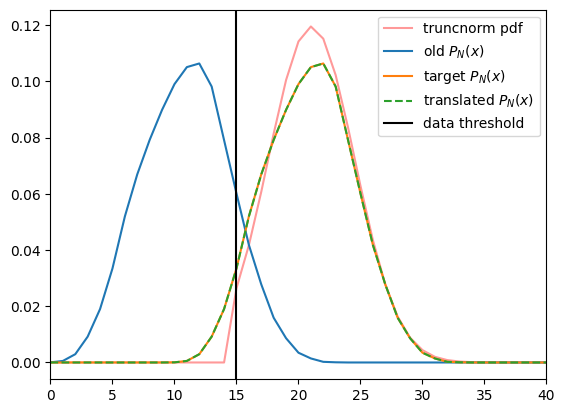

In [ ]:
import hilary
import os

cdfs=pd.read_csv(os.path.join(os.path.dirname(hilary.__file__),'cdfs/cdfs_human_jl.csv'))
cdf=cdfs.values[3][2:].astype(float)
pmf=cdf_to_pmf(cdf)
pmf2=np.concatenate([np.zeros(10),pmf[:-10]])
x_pmf=np.arange(len(pmf))

distance_threshold=15
data = np.random.choice(x_pmf, size=100000, p=pmf2)  # Replace with your data
data_before = np.random.choice(x_pmf, size=100000, p=pmf)  # Replace with your data

sel=data>distance_threshold

mean=np.mean(data_before)
std=np.mean(data_before)

# infer truncated normal 
new_data=data[sel]
a, b, loc, scale=fit_truncated_normal(new_data,mean,std,distance_threshold,80)
print(a, b, loc, scale)

new_mean = np.round(loc - mean).astype(int)
pmf3 = np.concatenate([np.zeros(new_mean),pmf[:-new_mean]])

plt.plot(x_pmf, truncnorm.pdf(x_pmf, a, b, loc=loc, scale=scale),
        'r-', alpha=0.4, label='truncnorm pdf')
plt.plot(x_pmf,pmf,label='old $P_N(x)$')
plt.plot(x_pmf,pmf2,label='target $P_N(x)$')
plt.plot(x_pmf,pmf3,'--',label='translated $P_N(x)$')
plt.axvline(distance_threshold,c='k',label='data threshold')
plt.xlim([0,40])
plt.legend()
plt.show()